# Stochastic partial differiential equations - Anisotropies

- The discretization depends on the dimension. See [1] and [2] for the details:

[1]	G.-A. Fuglstad, F. Lindgren, D. Simpson, and H. Rue, “Exploring a New Class of Non-Stationary Spatial Gaussian Random Fields with Varying Local Anisotropy,” Statistica Sinica, vol. 25, no. 1, pp. 115–133, 2015.

[2]	M. O. Berild and G.-A. Fuglstad, “Spatially varying anisotropy for Gaussian random fields in three-dimensional space,” Spatial Statistics, vol. 55, p. 100750, Jun. 2023, doi: 10.1016/j.spasta.2023.100750.

- Load the required modules

In [1]:
import logging
from pathlib import Path
import os
from typing import Optional, Union, Tuple, Callable
import numpy as np
import numpy.typing as npt
import scipy
import sksparse
from scipy.sparse import lil_matrix, csc_matrix
from sksparse.cholmod import cholesky, Factor
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
from nested_grid_plotter import NestedGridPlotter, multi_imshow
import spde
import gstools as gs

- Type hints definition for numpy arrays

In [2]:
NDArrayFloat = npt.NDArray[np.float64]
NDArrayInt = npt.NDArray[np.int64]
Int = Union[int, NDArrayInt]

- Set-up logging level

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions

In [4]:
logging.info(f"numpy version = {np.__version__}")
logging.info(f"scipy version = {scipy.__version__}")
logging.info(f"sksparse version = {sksparse.__version__}")
logging.info(f"matplotlib version = {mpl.__version__}")

INFO:root:numpy version = 1.23.5
INFO:root:scipy version = 1.9.1
INFO:root:sksparse version = 0.4.8
INFO:root:matplotlib version = 3.7.1


- Set a random number generator to obtain reproducible results. Here , we generate a seed from a cool sentence (Note: this is an incremental generator)


In [5]:
rng = np.random.default_rng(np.abs(hash("mike is the best")))

- Create a directory to store the exported figures

In [6]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

## Case of varying correlation range ($\kappa$)

- Function for linear_gradient

In [7]:
def linear_gradient(
    coords: NDArrayFloat, val_min: float, val_max: float
) -> NDArrayFloat:
    """_summary_

    Parameters
    ----------
    coords : NDArrayFloat
        Points coordinates (2, npts).
    vlr_min : float
        Minimum gradient value.
    val_max : float
        Maximum gradient value.

    Returns
    -------
    NDArrayFloat
        The gradient.
    """

    return np.exp(np.log(val_min) + (np.log(val_max) - np.log(val_min)) * coords[:, 0])

In [8]:
def create_grid_coordinates(shape: NDArrayInt, mesh_dim: NDArrayFloat) -> NDArrayFloat:
    """_summary_

    Parameters
    ----------
    shape : NDArrayInt
        _description_
    mesh_dim : NDArrayFloat
        _description_

    Returns
    -------
    NDArrayFloat
        _description_
    """
    xmin: NDArrayFloat = np.array((mesh_dim)) / 2.0
    xmax = (np.array(shape) - 0.5) * mesh_dim

    x1 = np.linspace(xmin[0], xmax[0], shape[0])
    x2 = np.linspace(xmin[1], xmax[1], shape[1])
    xx, yy = np.meshgrid(x1, x2, indexing="ij")
    return np.vstack((np.ravel(xx, order="F"), np.ravel(yy, order="F"))).transpose()

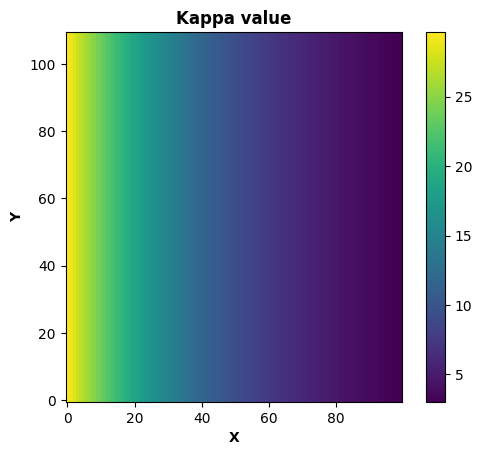

In [48]:
# We define nx and ny different to check the indexing
nx = 100
ny = 110  # grid size definition (meshes)
n_nodes = nx * ny  # number of meshes
dx = dy = 1.0 / nx  # mesh size
kappa = 30  # inverse of length scale
alpha = 1  # regularity parameter

coords = create_grid_coordinates(np.array([nx, ny]), np.array([dx, dy]))
varying_kappa = 1 / linear_gradient(coords, val_min=1 / kappa, val_max=1 / kappa * 10.0)

plt.imshow(varying_kappa.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Kappa value", fontweight="bold")
plt.colorbar()

- Create the precision matrices

In [49]:
nu = 2 * alpha - spatial_dim / 2
kappa
Q = spde.get_precision_matrix_2d(nx, ny, dx, dy, 1.0, alpha)

In [50]:
Q

<11000x11000 sparse matrix of type '<class 'numpy.float64'>'
	with 140904 stored elements in Compressed Sparse Row format>

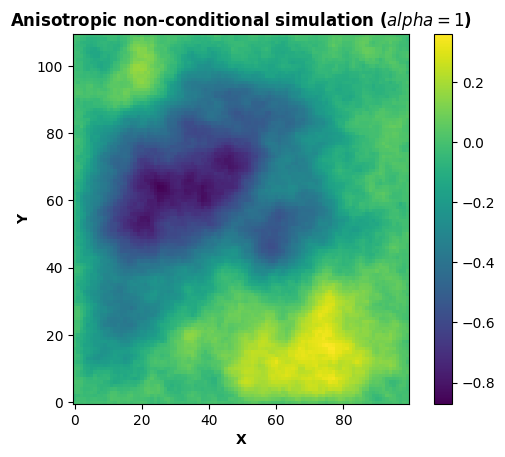

In [51]:
cholQ = cholesky(Q.tocsc())
z_nc = spde.simu_nc(cholQ, rng)

plt.imshow(z_nc.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Anisotropic non-conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

In [13]:
np.std(z_nc)

0.1387096876589426

## Dealing with anisotropies

In [14]:
def get_marginal_variance_2d(
    x: NDArrayFloat,
    y: NDArrayFloat,
    kappa: NDArrayFloat,
    dx: float,
    dy: float,
    anisotropy_function: Callable,
) -> NDArrayFloat:
    var_ = np.zeros(x.size)

    for i in range(x.size):
        var_[i] = scipy.linalg.det(anisotropy_function(x[i], y[i]))

    return 1.0 / (4 * np.pi * var_ * kappa**2) * np.sqrt(np.prod([dx, dy]))


def get_marginal_variance_3d(
    x: NDArrayFloat,
    y: NDArrayFloat,
    kappa: NDArrayFloat,
    dx: float,
    dy: float,
    dz: float,
    anisotropy_function: Callable,
) -> NDArrayFloat:
    var_ = np.zeros(x.size)

    for i in range(x.size):
        var_[i] = scipy.linalg.det(anisotropy_function(x[i], y[i], z[i]))

    return 1.0 / (8 * np.pi * var_ * kappa**2) * np.sqrt(np.prod([dx, dy, dz]))


def get_det(
    nx: int,
    ny: int,
    nz: int,
    dx: float,
    dy: float,
    dz: float,
    anisotropy_function: Callable[[float, float, float], NDArrayFloat],
) -> NDArrayFloat:
    size = nx * ny * nz
    # output array
    out = np.zeros(size)

    def get_linspace(_n, _d) -> NDArrayFloat:
        return np.linspace(0.5 * _d, (_n - 0.5) * _d, _n)

    # 3d version
    if nx != 1 and ny != 1 and nz != 1:
        X, Y, Z = np.meshgrid(
            get_linspace(nx, dx), get_linspace(ny, dy), get_linspace(nz, dz)
        )
        X = X.ravel()
        Y = Y.ravel()
        Z = Z.ravel()
        for i in range(size):
            out[i] = scipy.linalg.det(anisotropy_function(X[i], Y[i], Z[i]))
        return out

    # 2d version
    if ny != 1:
        X, Y = np.meshgrid(get_linspace(nx, dx), get_linspace(ny, dy))
        X = X.ravel()
        Y = Y.ravel()
        for i in range(size):
            out[i] = scipy.linalg.det(anisotropy_function(X[i], Y[i]))
        return out

    # 1d version
    for i in range(size):
        out[i] = scipy.linalg.det(anisotropy_function((i + 0.5) * dx))
    return out

In [15]:
kappa = 1.0
nx = 200
ny = 200
dx = dy = 0.1
alpha = 1
Q_test = spde.get_precision_matrix_2d(nx, ny, dx, dy, kappa, alpha)

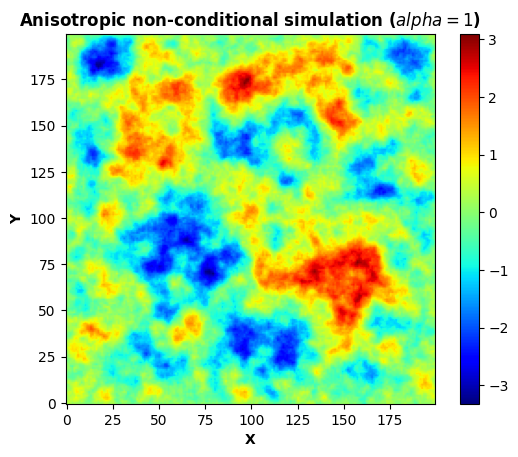

In [16]:
cholQ_test = cholesky(Q_test.tocsc())
z_nc_test = spde.simu_nc(cholQ_test, rng)

plt.imshow(z_nc_test.reshape(200, 200), origin="lower", cmap="jet")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Anisotropic non-conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

In [17]:
gamma = 1.0
beta = 8.0
theta = np.pi / 4
v = np.array([np.cos(theta), np.sin(theta)]).T

# TODO: maybe use a cache function ???

H = gamma * np.eye(2) + beta * v[:, np.newaxis] * v[:, np.newaxis].T


def _example31(x: float, y: float) -> NDArrayFloat:
    """Return a matrix."""
    return H.T

In [18]:
tau_31 = (
    np.sqrt(np.sqrt(get_det(nx, ny, 1, dx, dy, alpha, _example31)))
    * (kappa) ** nu
    * np.sqrt(np.math.gamma(2 * alpha))
    * (4 * np.pi) ** (2 / 4)
    / np.sqrt(np.math.gamma(nu))
)

tau_31_2 = (
    np.sqrt(get_det(nx, ny, 1, dx, dy, alpha, _example31))
    * (kappa) ** (2 * nu)
    * np.math.gamma(2 * alpha)
    * (4 * np.pi) ** (2 / 2)
    / np.math.gamma(nu)
)
tau_31

array([6.13996025, 6.13996025, 6.13996025, ..., 6.13996025, 6.13996025,
       6.13996025])

In [19]:
np.sqrt(tau_31_2)

array([6.13996025, 6.13996025, 6.13996025, ..., 6.13996025, 6.13996025,
       6.13996025])

In [20]:
Q_ex31 = spde.get_precision_matrix_2d(
    nx, ny, dx, dy, alpha=alpha, kappa=kappa, anisotropy_function=_example31
)

1.0


In [21]:
cholQ_ex31 = cholesky(Q_ex31.tocsc())
z_nc_ex31 = spde.simu_nc(cholQ_ex31, rng)

In [22]:
np.std(z_nc_ex31) * tau_31

array([0.7238697, 0.7238697, 0.7238697, ..., 0.7238697, 0.7238697,
       0.7238697])

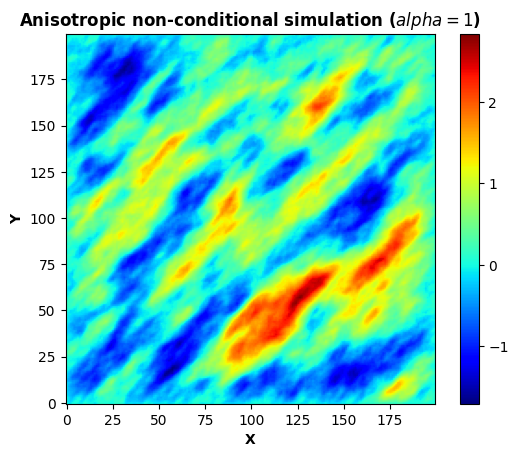

In [23]:
plt.imshow((z_nc_ex31 * tau_31).reshape(200, 200), origin="lower", cmap="jet")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Anisotropic non-conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

(array([   9.,   10.,   17.,   22.,   35.,   87.,  118.,  204.,  283.,
         317.,  321.,  427.,  516.,  570.,  631.,  827., 1030., 1167.,
        1268., 1374., 1496., 1543., 1801., 1913., 2196., 2367., 2376.,
        2241., 2063., 1924., 1660., 1478., 1365., 1135.,  942.,  785.,
         614.,  446.,  459.,  404.,  384.,  266.,  275.,  217.,  180.,
         126.,   60.,   33.,   13.,    5.]),
 array([-20.38225138, -19.59520255, -18.80815371, -18.02110488,
        -17.23405604, -16.44700721, -15.65995838, -14.87290954,
        -14.08586071, -13.29881187, -12.51176304, -11.7247142 ,
        -10.93766537, -10.15061653,  -9.3635677 ,  -8.57651886,
         -7.78947003,  -7.0024212 ,  -6.21537236,  -5.42832353,
         -4.64127469,  -3.85422586,  -3.06717702,  -2.28012819,
         -1.49307935,  -0.70603052,   0.08101832,   0.86806715,
          1.65511598,   2.44216482,   3.22921365,   4.01626249,
          4.80331132,   5.59036016,   6.37740899,   7.16445783,
          7.95150666,   

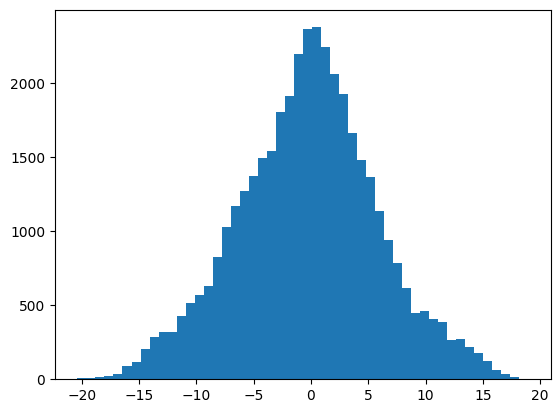

In [24]:
plt.hist(z_nc_test * tau_31, bins=50)

## Anisotropies in the non-stationary case

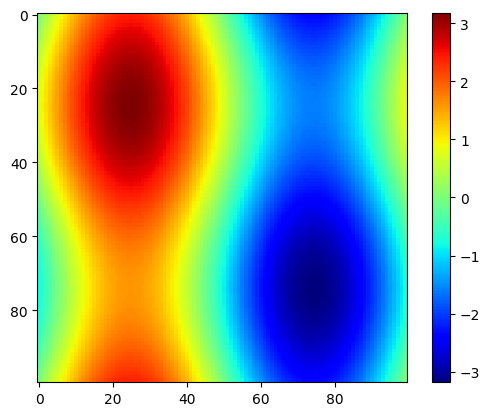

In [25]:
def _example32(x: float, y: float) -> float:
    """
    Return values to create a vector field.

    Parameters
    ----------
    x : float
        Position in meters.
    y : float
        Position in meters.

    Returns
    -------
    float
        Value
    """
    return (
        10
        / np.pi
        * (
            3.0 / 4.0 * np.sin(2 * np.pi * x / 20.0)
            + 1.0 / 4.0 * np.sin(2 * np.pi * y / 20.0)
        )
    )


X, Y = np.meshgrid(np.linspace(0, 20, 100), np.linspace(0, 20, 100))

field = _example32(X, Y)

plt.imshow(field, cmap="jet")
plt.colorbar()

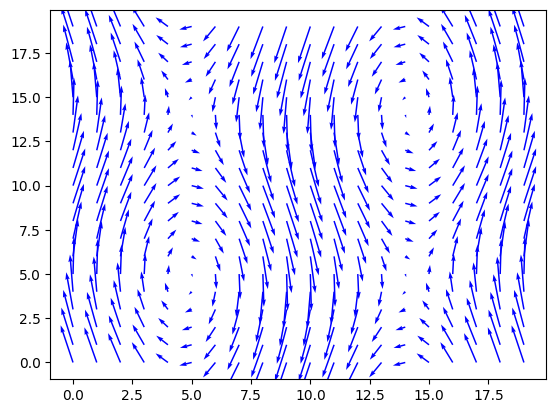

In [26]:
def _example32_gradient(x: float, y: float) -> float:
    """
    Return values to create a vector field.

    Parameters
    ----------
    x : float
        Position in meters.
    y : float
        Position in meters.

    Returns
    -------
    float
        Value
    """
    return (
        10
        / np.pi
        * np.array(
            [
                -1.0 / 4.0 * np.cos(2 * np.pi * y / 20.0) * 2 * np.pi / 20.0,
                3.0 / 4.0 * np.cos(2 * np.pi * x / 20.0) * 2 * np.pi / 20.0,
            ]
        )
    )


X, Y = np.meshgrid(np.linspace(0, 20, 20), np.linspace(0, 20, 20))
gradient_field = _example32_gradient(X, Y)

plt.quiver(gradient_field[0], gradient_field[1], scale=10, color="blue")

In [27]:
def _wrapper_ex32(x: float, y: float) -> NDArrayFloat:
    v = _example32_gradient(x, y)
    return (0.1 * np.eye(2) + 25 * v[:, np.newaxis] * v[:, np.newaxis].T).T

In [28]:
X1, X2 = np.array([3, 4, 5]), np.array([3, 4, 5])

for i in range(X1.size):
    print(scipy.linalg.det(_wrapper_ex32(X1[i], X2[i])))

0.5498304731445718
0.15920547314457245
0.010000000000000002


In [29]:
nx = ny = 200
dx = dy = 0.1
X, Y = np.meshgrid(np.linspace(0.0, nx * dx, nx), np.linspace(0.0, ny * dy, ny))

# _example32_gradient(X.ravel(), Y.ravel())
# _wrapper_ex32(X.ravel(), Y.ravel()).reshape(nx, ny)
X = X.ravel()
Y = Y.ravel()


marginal_variance = get_marginal_variance_2d(Y, X, 1.0, dx, dy, _wrapper_ex32)

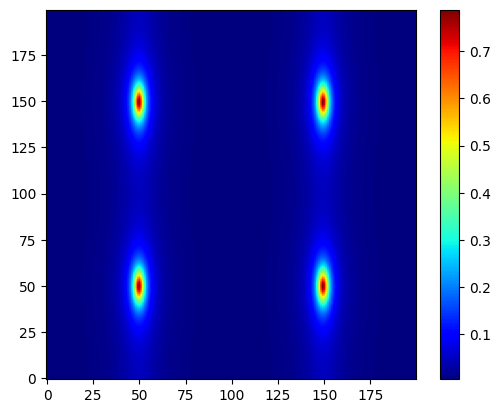

In [30]:
plt.imshow(marginal_variance.reshape(nx, ny).T, origin="lower", cmap="jet")
plt.colorbar()

In [31]:
Q_ex32 = spde.get_precision_matrix_2d(
    200, 200, 0.1, 0.1, 1.0, kappa, anisotropy_function=_wrapper_ex32
)

1.0


In [32]:
tau_32 = (
    np.sqrt(np.sqrt(get_det(nx, ny, 1, dx, dy, 1.0, _wrapper_ex32)))
    * (kappa) ** nu
    * np.sqrt(np.math.gamma(2 * alpha))
    * (4 * np.pi) ** (2 / 4)
    / np.sqrt(np.math.gamma(nu))
)

tau_32_2 = (
    np.sqrt(get_det(nx, ny, 1, dx, dy, 1.0, _wrapper_ex32))
    * (kappa) ** (2 * nu)
    * np.math.gamma(2 * alpha)
    * (4 * np.pi) ** (2 / 2)
    / np.math.gamma(nu)
)
tau_32

array([3.96941015, 3.96765827, 3.96415446, ..., 3.96415446, 3.96765827,
       3.96941015])

In [33]:
np.sqrt(tau_32_2)

array([3.96941015, 3.96765827, 3.96415446, ..., 3.96415446, 3.96765827,
       3.96941015])

In [34]:
np.sqrt(np.sqrt(marginal_variance))

array([0.26671649, 0.2667231 , 0.26674288, ..., 0.26674288, 0.2667231 ,
       0.26671649])

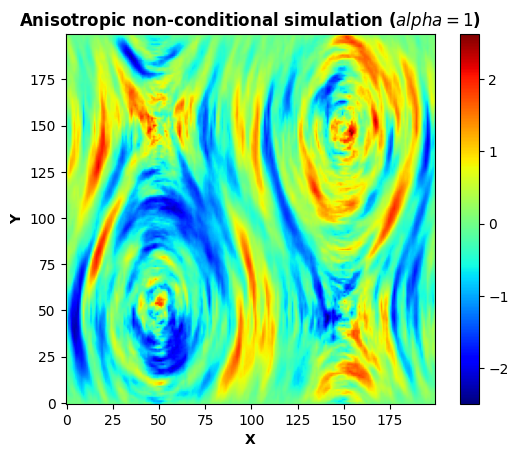

In [35]:
cholQ_ex32 = cholesky(Q_ex32.tocsc())
z_nc_ex32 = spde.simu_nc(cholQ_ex32, rng)

plt.imshow((z_nc_ex32 * tau_32).reshape(200, 200), origin="lower", cmap="jet")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Anisotropic non-conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

In [36]:
np.std(z_nc_ex32 * tau_32)

0.7627050245513487

(array([3.000e+00, 3.000e+00, 3.100e+01, 6.900e+01, 8.300e+01, 1.260e+02,
        1.450e+02, 2.210e+02, 3.100e+02, 4.130e+02, 5.430e+02, 6.650e+02,
        7.290e+02, 8.510e+02, 9.480e+02, 1.106e+03, 1.162e+03, 1.361e+03,
        1.548e+03, 1.775e+03, 1.961e+03, 2.071e+03, 2.190e+03, 2.275e+03,
        2.281e+03, 2.091e+03, 2.073e+03, 1.843e+03, 1.636e+03, 1.397e+03,
        1.322e+03, 1.178e+03, 1.123e+03, 9.700e+02, 7.930e+02, 6.550e+02,
        5.580e+02, 3.970e+02, 3.080e+02, 2.670e+02, 1.860e+02, 1.230e+02,
        1.010e+02, 6.800e+01, 2.200e+01, 1.300e+01, 2.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00]),
 array([-2.49032269, -2.38805603, -2.28578937, -2.18352271, -2.08125605,
        -1.9789894 , -1.87672274, -1.77445608, -1.67218942, -1.56992276,
        -1.4676561 , -1.36538945, -1.26312279, -1.16085613, -1.05858947,
        -0.95632281, -0.85405615, -0.7517895 , -0.64952284, -0.54725618,
        -0.44498952, -0.34272286, -0.2404562 , -0.13818955, -0.03592289,
         0.

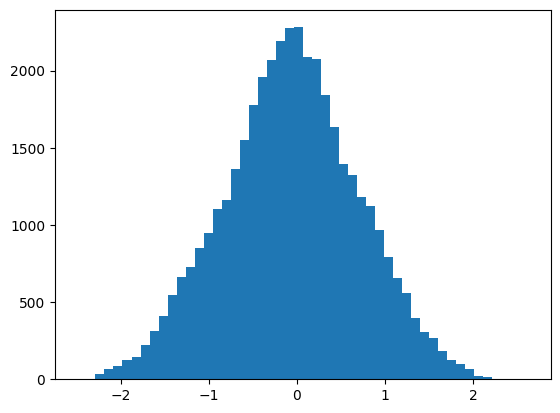

In [37]:
plt.hist(z_nc_ex32 * tau_32, bins=50)

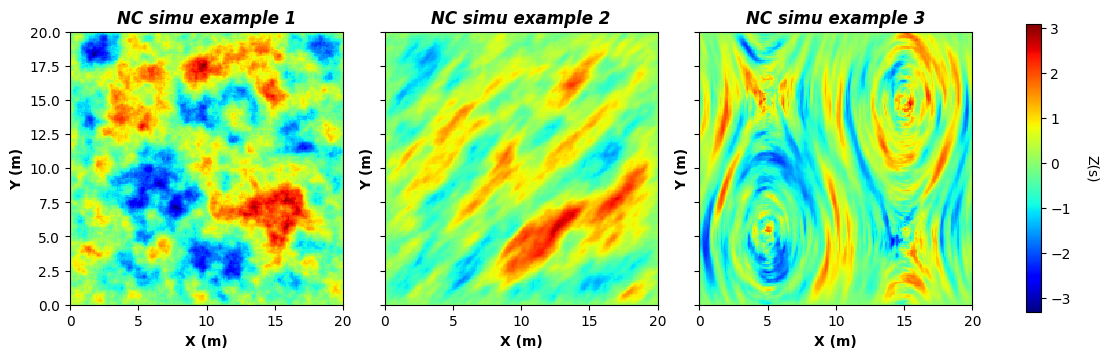

In [38]:
from nested_grid_plotter import NestedGridPlotter

plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (11, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "NC simu example 1": z_nc_test.reshape(200, 200).T,
        "NC simu example 2": (z_nc_ex31 * tau_31).reshape(200, 200).T,
        "NC simu example 3": (z_nc_ex32 * tau_32).reshape(200, 200).T,
    },
    cbar_title="Z(s)",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "extent": [0.0, 20, 0.0, 20],
        "aspect": "equal"
        # "vmin": 50,
        # "vmax": 650,
    },
    xlabel="X (m)",
    ylabel="Y (m)",
)

fname = "nc_simu_anisotropy"
for format in ["png", "pdf"]:
    plotter.fig.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

## Example roll front

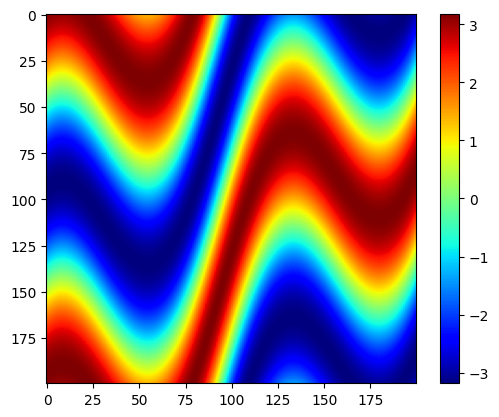

In [39]:
def example_roll_front(x: float, y: float) -> float:
    """
    Return values to create a vector field.

    Parameters
    ----------
    x : float
        Position in meters.
    y : float
        Position in meters.

    Returns
    -------
    float
        Value
    """
    # return np.cos(2 * np.pi * (x / 20 + y / 20))
    return (
        10 / np.pi * (np.sin((2 * np.pi * (y + 5 * np.cos(x / 2) + x) + np.pi) / 20.0))
    )


nx = ny = 200
dx = dy = 0.1
X, Y = np.meshgrid(np.linspace(0.0, nx * dx, nx), np.linspace(0.0, ny * dy, ny))

# _example32_gradient(X.ravel(), Y.ravel())
# _wrapper_ex32(X.ravel(), Y.ravel()).reshape(nx, ny)
X = X.ravel()
Y = Y.ravel()

# X, Y = np.meshgrid(np.linspace(0, 20, 100), np.linspace(0, 20, 100))

field = example_roll_front(X, Y).reshape(nx, ny)

plt.imshow(field, cmap="jet")
plt.colorbar()

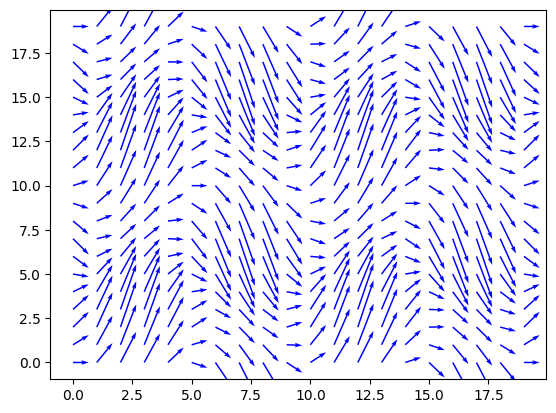

In [40]:
def example_roll_front_gradient(x: float, y: float) -> NDArrayFloat:
    """
    Return values to create a vector field.

    Parameters
    ----------
    x : float
        Position in meters.
    y : float
        Position in meters.

    Returns
    -------
    float
        Value
    """
    return (
        10
        / np.pi
        * np.array(
            [
                (1 / (20**2))
                * (40 * np.pi - 100 * np.pi * np.sin(x / 2))
                * np.cos((2 * np.pi * (y + 5 * np.cos(x / 2) + x) + np.pi) / 20.0),
                -(1 / 20**2)
                * (
                    40
                    * np.pi
                    * np.sin((2 * np.pi * (y + 5 * np.cos(x / 2) + x) + np.pi) / 20.0)
                ),
            ]
        )
    )


def example_roll_front_gradient(x: float, y: float) -> NDArrayFloat:
    """
    Return values to create a vector field.

    Parameters
    ----------
    x : float
        Position in meters.
    y : float
        Position in meters.

    Returns
    -------
    float
        Value
    """
    # cos(x+2*y), sin(x-2*y)
    return (
        10
        / np.pi
        * np.array(
            [
                x * 0.0 + 1.0,  # -np.cos(np.pi * x),
                2 * np.sin(np.pi * (x) / 5) + np.sin((np.pi * (y) / 5)),
            ]
        )
    )


X2, Y2 = np.meshgrid(np.linspace(0, 20, 20), np.linspace(0, 20, 20))

gradient_field = example_roll_front_gradient(X2, Y2)

plt.quiver(gradient_field[0], gradient_field[1], scale=100, color="blue")

In [41]:
def wrapper_ex_rf(x: float, y: float) -> NDArrayFloat:
    v = example_roll_front_gradient(x, y)
    return (0.1 * np.eye(2) + 25 * v[:, np.newaxis] * v[:, np.newaxis].T).T

In [42]:
tau_rf = (
    np.sqrt(np.sqrt(get_det(nx, ny, 1, dx, dy, 1.0, wrapper_ex_rf)))
    * (kappa) ** nu
    * np.sqrt(np.math.gamma(2 * alpha))
    * (4 * np.pi) ** (2 / 4)
    / np.sqrt(np.math.gamma(nu))
)

tau_rf_2 = (
    np.sqrt(get_det(nx, ny, 1, dx, dy, 1.0, wrapper_ex_rf))
    * (kappa) ** (2 * nu)
    * np.math.gamma(2 * alpha)
    * (4 * np.pi) ** (2 / 2)
    / np.math.gamma(nu)
)
tau_rf

array([7.97108286, 8.04767942, 8.17928001, ..., 8.17928001, 8.04767942,
       7.97108286])

In [43]:
np.sqrt(tau_rf_2)

array([7.97108286, 8.04767942, 8.17928001, ..., 8.17928001, 8.04767942,
       7.97108286])

In [44]:
Q_ex_rf = spde.get_precision_matrix_2d(
    nx, ny, dx, dy, alpha=alpha, kappa=kappa, anisotropy_function=wrapper_ex_rf
)

1.0


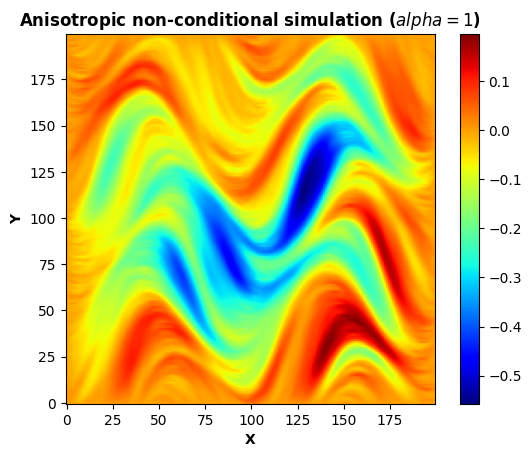

In [45]:
cholQ_ex_rf = cholesky(Q_ex_rf.tocsc())
z_nc_ex_rf = spde.simu_nc(cholQ_ex_rf, rng)

plt.imshow((z_nc_ex_rf * tau_rf).reshape(200, 200), origin="lower", cmap="jet")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Anisotropic non-conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

In [46]:
# marginal_variance = get_marginal_variance_2d(Y, X, 1.0, dx, dy, _wrapper_ex32)

marginal_variance_rf = get_marginal_variance_2d(X, Y, 1.0, dx, dy, wrapper_ex_rf)

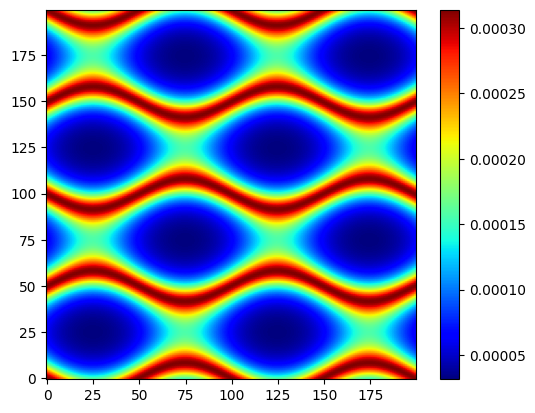

In [47]:
plt.imshow(marginal_variance_rf.reshape(nx, ny).T, origin="lower", cmap="jet")
plt.colorbar()

# 3D case

# TODO